Noah Grenninger
July 2024
A project to study characteristics of solar eclipses and how they affect each other

Data Wrangling
I used a solar eclipse dataset from Kaggle, the information in it was complied from a NASA website and table of 
an eclipse almanac.
I then did a few manual alterations to the dataset inside of excel to make it more useable:
    Added column for eclipse duration in seconds
    added column for lat and lon as just a number (doesn't specify from North and south)
    changed eclipse types to numeric number from character

In [1]:
# Import Libraries
import csv
import numpy as np
import pandas as pd
import sqlite3
import itertools 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model as linear_model
import sklearn.datasets as datasets
import sklearn.model_selection as model_selection

In [2]:
# load csv containing data
solar = pd.read_csv("solar_rework1.csv")

In [3]:
# display dataframe 

# NOTE 
# ----------------------
# for Eclipse type
# 2 = Total Eclipse
# 1 = Anular Eclipse
# 3 = Hybrid Eclipse
# 4 = Partial Eclipse

print(solar.head(5))

   Catalog Number      Calendar Date Eclipse Time  Delta T (s)  \
0               1      -1999 June 12      3:14:51        46438   
1               2   -1999 December 5     23:45:23        46426   
2               3       -1998 June 1     18:09:16        46415   
3               4  -1998 November 25      5:57:03        46403   
4               5     -1997 April 22     13:19:56        46393   

   Lunation Number  Saros Number  Eclipse Type  Gamma  Eclipse Magnitude  \
0           -49456             5             2  -0.27               1.07   
1           -49450            10             1  -0.23               0.94   
2           -49444            15             2   0.50               1.03   
3           -49438            20             1  -0.90               0.98   
4           -49433           -13             4  -1.47               0.16   

  Latitude Longitude  Sun Altitude  Sun Azimuth  Path Width (km)  \
0     6.0N     33.3W            74          344            247.0   
1    32.9S

More Data cleansing
For this project I only want to analyize eclipses that have a central path, this is every type other than Partial.
Since partial eclipses have no values for the path width and central duration I will remove them by
deleting them along with all other rows that are missing values or have incomplete data. 

In [4]:
missing_rows, missing_cols = np.where(pd.isna(solar))
print("There are,", len(missing_rows), " rows with missing data")

There are, 8400  rows with missing data


In [5]:
# drop rows that are missing data
solar.drop(missing_rows, inplace = True)


In [6]:
# find shape to see how many records are remaining
solar.shape

(7698, 18)

In [7]:
# check for duplicated data
duplicates = solar[solar.duplicated()]
print("There are,", len(duplicates), " rows with duplicated data")

There are, 0  rows with duplicated data


In [8]:
# drop columns that do not have useful data
solar = solar.drop('Lunation Number', axis=1)
solar = solar.drop('Delta T (s)', axis=1)

In [9]:
# display the data types for each column 
solar.dtypes

Catalog Number         int64
Calendar Date         object
Eclipse Time          object
Saros Number           int64
Eclipse Type           int64
Gamma                float64
Eclipse Magnitude    float64
Latitude              object
Longitude             object
Sun Altitude           int64
Sun Azimuth            int64
Path Width (km)      float64
Central Duration      object
Duration S             int64
Lat                  float64
Lon                  float64
dtype: object

In [10]:
annular = solar[solar['Eclipse Type']== 1]
total = solar[solar['Eclipse Type']== 2]
hybrid = solar[solar['Eclipse Type']== 3]
# find the amount of records of each type
print(annular.shape, total.shape, hybrid.shape)

(3956, 16) (3173, 16) (569, 16)


create new data frames for each type of eclipse

In [11]:

# find mean of the length of each eclipse type
solar.groupby(['Eclipse Type'])['Duration S'].mean()

Eclipse Type
1    283.520981
2    220.852821
3     43.031634
Name: Duration S, dtype: float64

In [12]:
# find eclipses with the widest paths
total.sort_values(by=['Path Width (km)'], ascending = False)


,Catalog Number,Calendar Date,Eclipse Time,Saros Number,Eclipse Type,Gamma,Eclipse Magnitude,Latitude,Longitude,Sun Altitude,Sun Azimuth,Path Width (km),Central Duration,Duration S,Lat,Lon
3752,3753,-434 April 21,17:18:50,41,2,-0.98,1.06,56.5S,40.8E,10,306,1017.0,03m29s,209,56.5,40.8
9007,9008,1787 June 15,15:59:25,114,2,0.97,1.06,78.7N,104.8E,12,346,998.0,03m09s,189,78.7,104.8
7735,7736,1248 May 24,12:24:47,96,2,0.98,1.05,78.2N,170.9W,11,13,997.0,02m42s,162,78.2,170.9
9032,9033,1797 June 24,16:18:13,143,2,0.98,1.06,77.2N,133.9E,11,17,975.0,02m47s,167,77.2,133.9
3045,3046,-716 June 16,22:15:24,35,2,-0.97,1.06,52.4S,52.2W,13,343,874.0,04m21s,261,52.4,52.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4188,4189,-243 December 31,15:35:17,47,2,-1.00,1.01,65.0S,162.5E,0,199,0.0,0,0,65.0,162.5
4147,4148,-261 December 21,6:47:13,47,2,-0.99,1.03,71.0S,56.5W,5,190,0.0,01m24s,84,71.0,56.5
4107,4108,-279 December 9,21:55:28,47,2,-0.99,1.03,73.7S,91.4E,7,176,0.0,01m25s,85,73.7,91.4
4082,4083,-290 August 15,12:34:54,79,2,1.00,1.01,70.0N,168.9W,0,323,0.0,0,0,70.0,168.9


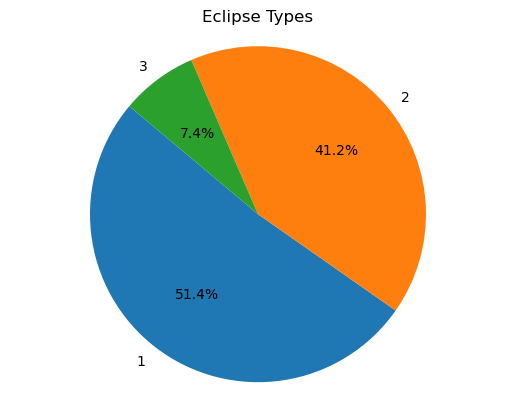

In [13]:
# Pie Chart with Eclipse Types
# 1 = Annular
# 2 = Total
# 3 = Hybrid

types = solar['Eclipse Type']
types_counts = types.value_counts()

plt.pie(types_counts, labels=types_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Eclipse Types")
plt.show()

In [14]:
print("The skew of the annular magnitude is: ", annular['Eclipse Magnitude'].skew()," and the skew of the total magnitude is: ",
total['Eclipse Magnitude'].skew())

The skew of the annular magnitude is:  0.13108491454180654  and the skew of the total magnitude is:  0.030280873203766743


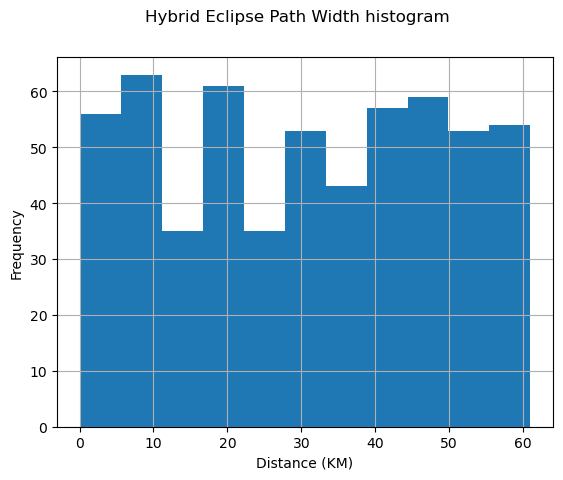

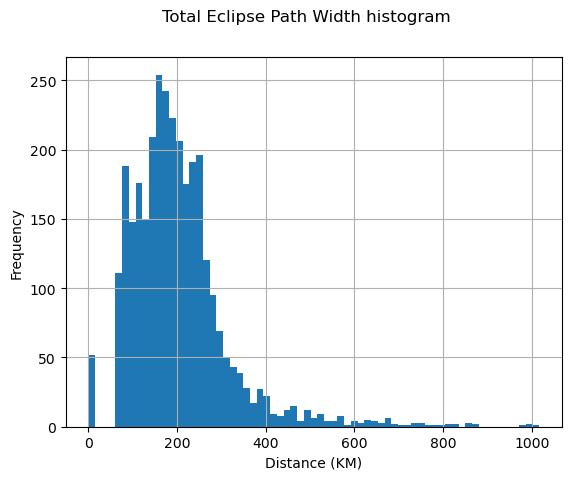

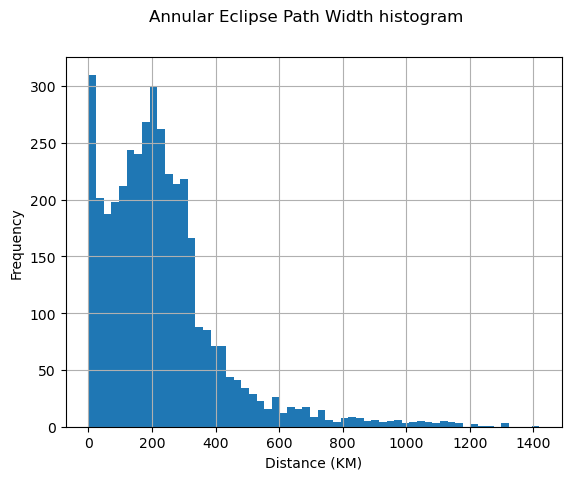

In [42]:
# make a histogram displaying path width for each eclipse type
hybrid['Path Width (km)'].hist(bins='auto')
plt.suptitle("Hybrid Eclipse Path Width histogram")
plt.xlabel('Distance (KM)')
plt.ylabel('Frequency')
plt.show()

total['Path Width (km)'].hist(bins='auto')
plt.suptitle("Total Eclipse Path Width histogram")
plt.xlabel('Distance (KM)')
plt.ylabel('Frequency')
plt.show()

annular['Path Width (km)'].hist(bins='auto')
plt.suptitle("Annular Eclipse Path Width histogram")
plt.xlabel('Distance (KM)')
plt.ylabel('Frequency')
plt.show()



In [40]:
# sort by duration (find data for longest hybrid eclipes)
hybrid.sort_values(by=['Path Width (km)'], ascending = False)

,Catalog Number,Calendar Date,Eclipse Time,Saros Number,Eclipse Type,Gamma,Eclipse Magnitude,Latitude,Longitude,Sun Altitude,Sun Azimuth,Path Width (km),Central Duration,Duration S,Lat,Lon
6854,6855,881 March 4,3:08:22,102,3,-0.36,1.02,25.1S,152.4E,69,341,61.0,01m35s,95,25.1,152.4
8793,8794,1703 January 17,11:24:25,136,3,-0.73,1.01,67.9S,22.2E,42,347,61.0,00m50s,50,67.9,22.2
4028,4029,-314 November 7,18:59:06,57,3,-0.34,1.02,34.7S,53.9W,70,15,61.0,01m30s,90,34.7,53.9
5127,5128,143 October 25,22:40:07,84,3,-0.44,1.02,35.1S,139.1W,64,32,60.0,01m18s,78,35.1,139.1
10429,10430,2386 April 29,12:32:25,154,3,-0.55,1.01,18.1S,2.9E,57,347,60.0,01m30s,90,18.1,2.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9350,9351,1930 April 28,19:03:34,137,3,0.47,1.00,39.4N,121.2W,62,149,1.0,00m01s,1,39.4,121.2
9478,9479,1986 October 3,19:06:15,124,3,0.99,1.00,59.9N,37.1W,5,252,1.0,00m00s,0,59.9,37.1
9048,9049,1804 February 11,11:16:33,137,3,0.71,1.00,26.7N,4.5W,45,153,0.0,00m00s,0,26.7,4.5
4529,4530,-97 March 17,23:02:59,57,3,-0.55,1.00,31.4S,96.6W,56,325,0.0,00m00s,0,31.4,96.6


In [64]:
# sort by duration (find data for longest eclipes
total.sort_values(by=['Duration S'], ascending = False)

,Catalog Number,Calendar Date,Eclipse Time,Saros Number,Eclipse Type,Gamma,Eclipse Magnitude,Latitude,Longitude,Sun Altitude,Sun Azimuth,Path Width (km),Central Duration,Duration S,Lat,Lon
9932,9933,2186 July 16,15:14:54,139,2,-0.24,1.08,7.4N,46.5W,76,4,267.0,07m29s,449,7.4,46.5
2980,2981,-743 June 15,14:27:14,54,2,-0.40,1.08,0.7S,48.8E,66,359,279.0,07m28s,448,0.7,48.8
9888,9889,2168 July 5,7:45:23,139,2,-0.17,1.08,13.2N,66.4E,81,0,264.0,07m26s,446,13.2,66.4
2938,2939,-761 June 5,7:01:07,54,2,-0.47,1.08,6.8S,163.3E,62,355,292.0,07m25s,445,6.8,163.3
5622,5623,363 June 27,21:46:29,81,2,-0.19,1.08,12.7N,116.8W,79,357,264.0,07m24s,444,12.7,116.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2613,2614,-905 March 10,18:32:35,54,2,-1.01,1.01,71.4S,117.5E,0,245,0.0,0,0,71.4,117.5
2606,2607,-909 November 15,16:55:23,57,2,1.00,1.01,69.8N,58.5E,0,215,0.0,0,0,69.8,58.5
2591,2592,-915 February 28,18:57:40,25,2,-1.00,1.00,61.2S,110.1E,0,246,0.0,0,0,61.2,110.1
9602,9603,2043 April 9,18:57:49,149,2,1.00,1.01,61.3N,152.0E,0,74,0.0,0,0,61.3,152.0


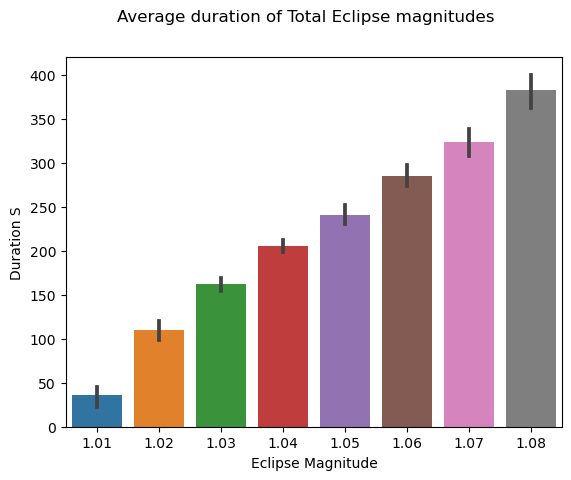

In [48]:
sub1 = solar[solar['Eclipse Type']==2].tail(300)
ax = sns.barplot(x = "Eclipse Magnitude", y = "Duration S", data = sub1)
plt.suptitle("Average duration of Total Eclipse magnitudes")
plt.show()

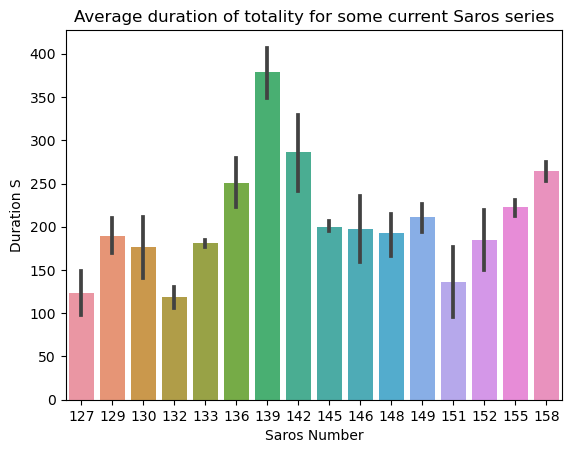

In [45]:
sub2 = solar[solar['Eclipse Type']==2].tail(615)
sub3 = sub2.head(180)
ax = sns.barplot(x = "Saros Number", y = "Duration S", data = sub3)
plt.title("Average duration of totality for some current Saros series")
plt.show()

In [19]:
# average duration of totality for all saros series (that have total solar eclipses) 
total.groupby(['Saros Number'])['Duration S'].mean()

Saros Number
-2      226.375000
-1       81.166667
 1      166.166667
 2      107.333333
 4      180.909091
           ...    
 174     33.000000
 176    180.600000
 177     70.666667
 179    209.714286
 180    108.250000
Name: Duration S, Length: 140, dtype: float64

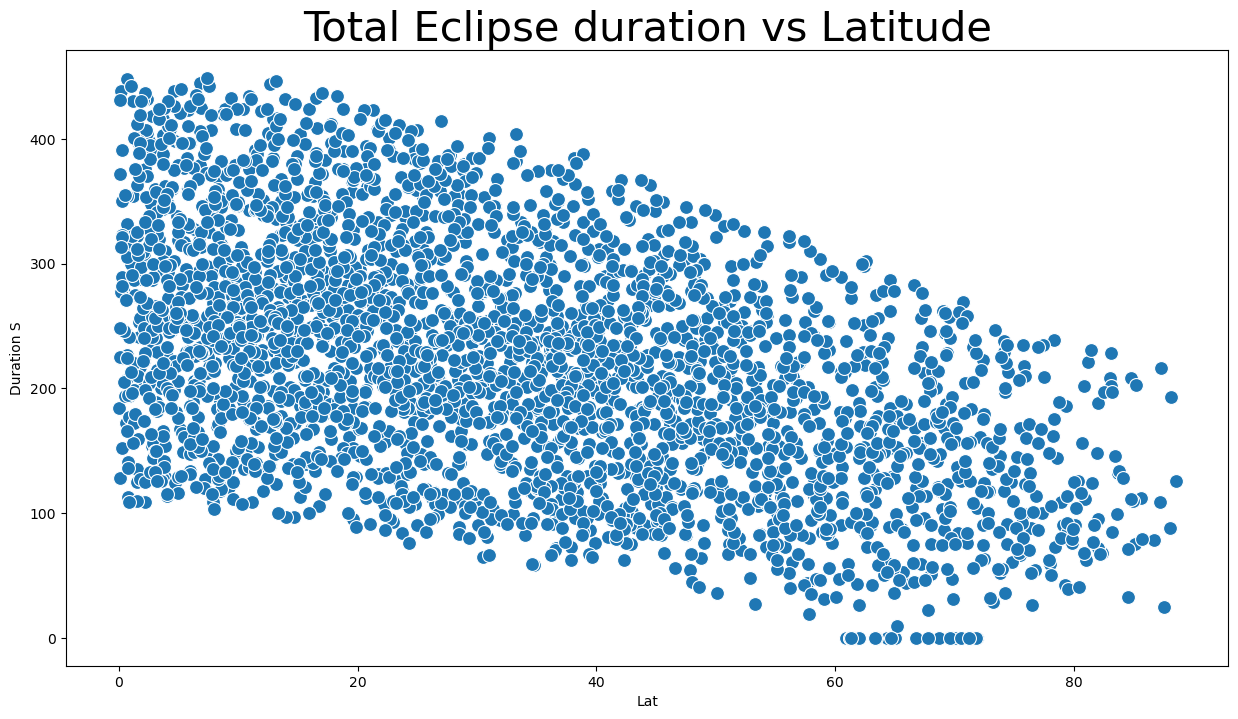

In [61]:
# make a scatterplot comparing eclipse duration to eclipse path width
sub = total[['Lat', 'Duration S']]
plt.figure(figsize=(15,8))
sns.scatterplot(data=sub, x=sub['Lat'], y=sub['Duration S'], s=100)
plt.title("Total Eclipse duration vs Latitude", fontsize=30)
plt.show()

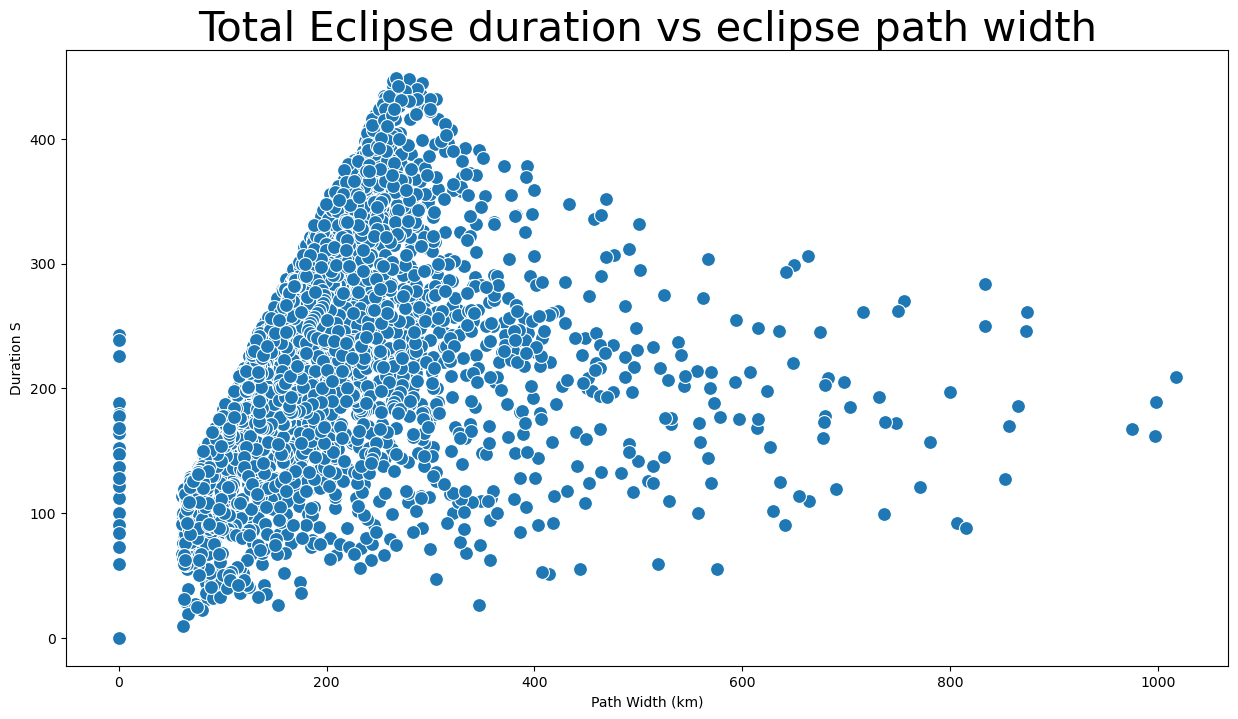

In [58]:
# make a scatterplot comparing eclipse duration to eclipse path width
sub = total[['', 'Duration S']]
plt.figure(figsize=(15,8))
sns.scatterplot(data=sub, x=sub['Path Width (km)'], y=sub['Duration S'], s=100)
plt.title("Total Eclipse duration vs eclipse path width", fontsize=30)
plt.show()

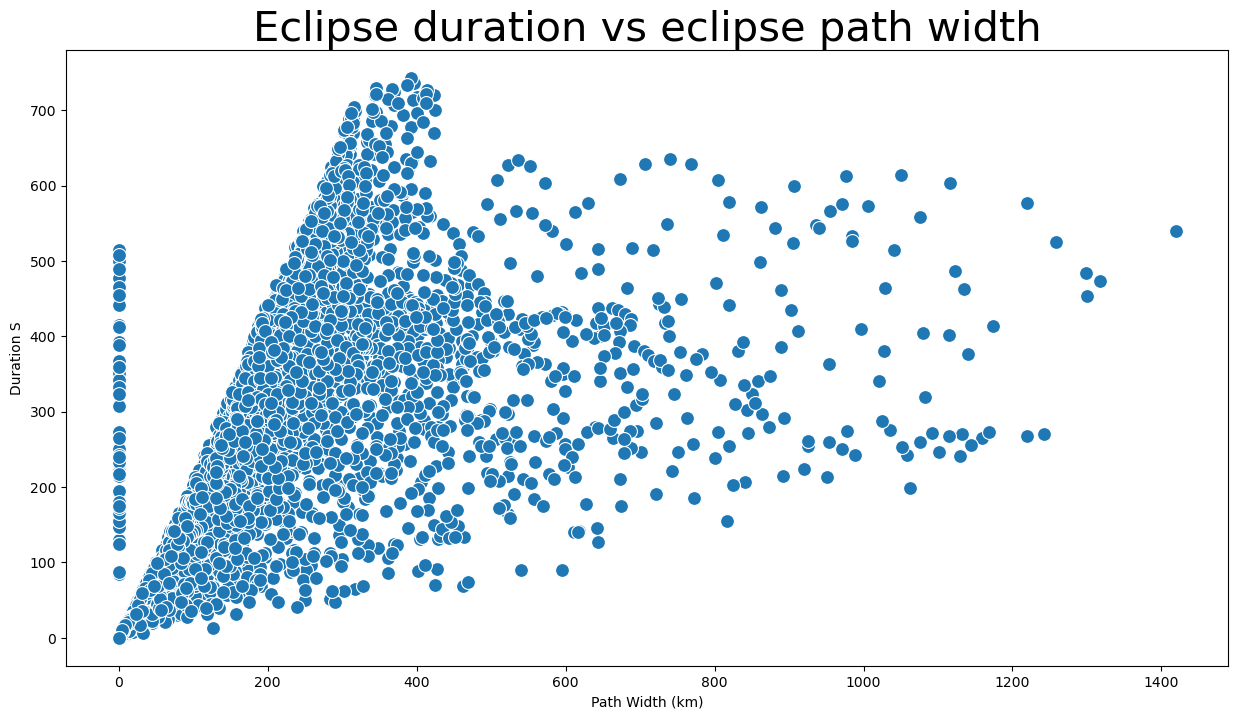

In [37]:
# make a scatterplot comparing eclipse duration to eclipse path width for Annular eclipses
subA = annular[['Path Width (km)', 'Duration S']]
plt.figure(figsize=(15,8))
sns.scatterplot(data=sub, x=subA['Path Width (km)'], y=subA['Duration S'], s=100)
plt.title("Eclipse duration vs eclipse path width", fontsize=30)
plt.show()

Start working on logistic regression model for determining eclipse duration of total solar eclipses

<Axes: >

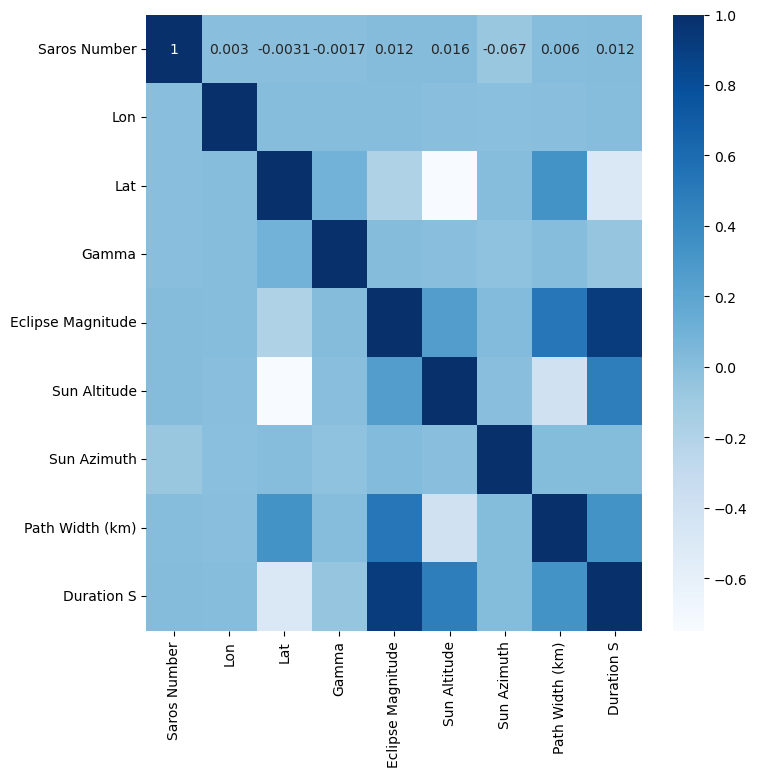

In [22]:
# make a dataframe with only the numeric values in the total df
total_nums = total[['Saros Number','Lon', 'Lat', 'Gamma', 'Eclipse Magnitude', 'Sun Altitude', 'Sun Azimuth', 'Path Width (km)', 'Duration S',]]

# find correlation between values
correlation = total_nums.corr()
fix,ax = plt.subplots(figsize=(8,8))
sns.heatmap(correlation, annot=True, cmap="Blues", ax=ax,  annot_kws={"size":10})


In [23]:
# Create a df for the values that will be used for the model
values = total_nums[['Path Width (km)', 'Sun Altitude', 'Eclipse Magnitude', 'Lat']]
target = total_nums[['Duration S']]
# print df shapes to make sure their sizes match
print(target.shape, values.shape)


(3173, 1) (3173, 4)


In [24]:
#convert to numpy arrays
value_arr = values.to_numpy()
target_arr = target.to_numpy()
print(value_arr.shape)
print(target_arr.shape)

(3173, 4)
(3173, 1)


In [25]:
# break up array into train and test data
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(value_arr, target_arr, train_size = 0.80, random_state = 0)

In [26]:
# check sizes of arrays
print("size of x: ", X_test.shape)
print("size of x: ", X_train.shape)

size of x:  (635, 4)
size of x:  (2538, 4)


In [27]:
# create linear regression model
lm = linear_model.LinearRegression()
lm.fit(X_train, Y_train)

LinearRegression()

In [28]:
print("coefficients are: Path Width, Sun Altitude, Eclipse Magnitude, Lat", lm.coef_)


coefficients are: Path Width, Sun Altitude, Eclipse Magnitude, Lat [[ 3.33699338e-03  1.52633775e-01  4.33481893e+03 -1.31579283e+00]]


In [29]:
# print the intercept
print("Intercept: ", lm.intercept_)

Intercept:  [-4275.21642586]


In [30]:
# look at training data vs predicted data
y_train_pred = lm.predict(X_train)
y_test_pred = lm.predict(X_test)
target_arr_pred = lm.predict(value_arr)

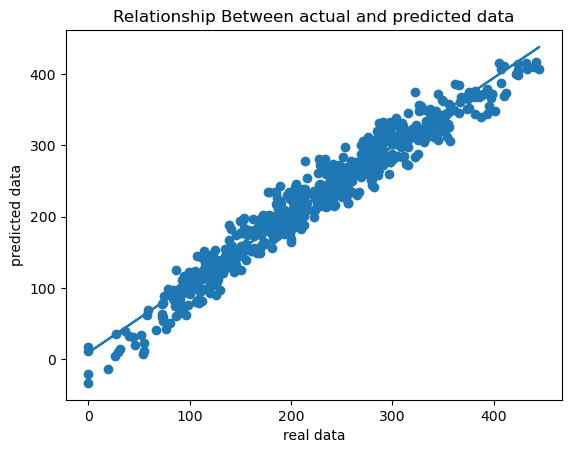

In [31]:
# review data to see if the model was good
plt.scatter(Y_test, y_test_pred)
plt.xlabel("real data")
plt.ylabel("predicted data")

# Fit a line of best fit
m, b = np.polyfit(Y_test.flatten(), y_test_pred.flatten(), 1)
plt.plot(Y_test, m*Y_test + b)

plt.title("Relationship Between actual and predicted data")
plt.show()

Review the model

In [32]:
# import needed utils
from sklearn.metrics import mean_squared_error
from sklearn.metrics import max_error
from sklearn.metrics import r2_score
from sklearn.metrics import median_absolute_error
from matplotlib import pyplot

In [33]:
# find accuracy of model
print("The r2 value is: ")
r2_score(Y_test, y_test_pred)

The r2 value is: 


0.9488861359506588

In [34]:
print("The max squared error is: ")
max_error(Y_test, y_test_pred)

The max squared error is: 


64.14238913188547

(635, 1)
(635, 1)
(635, 4)


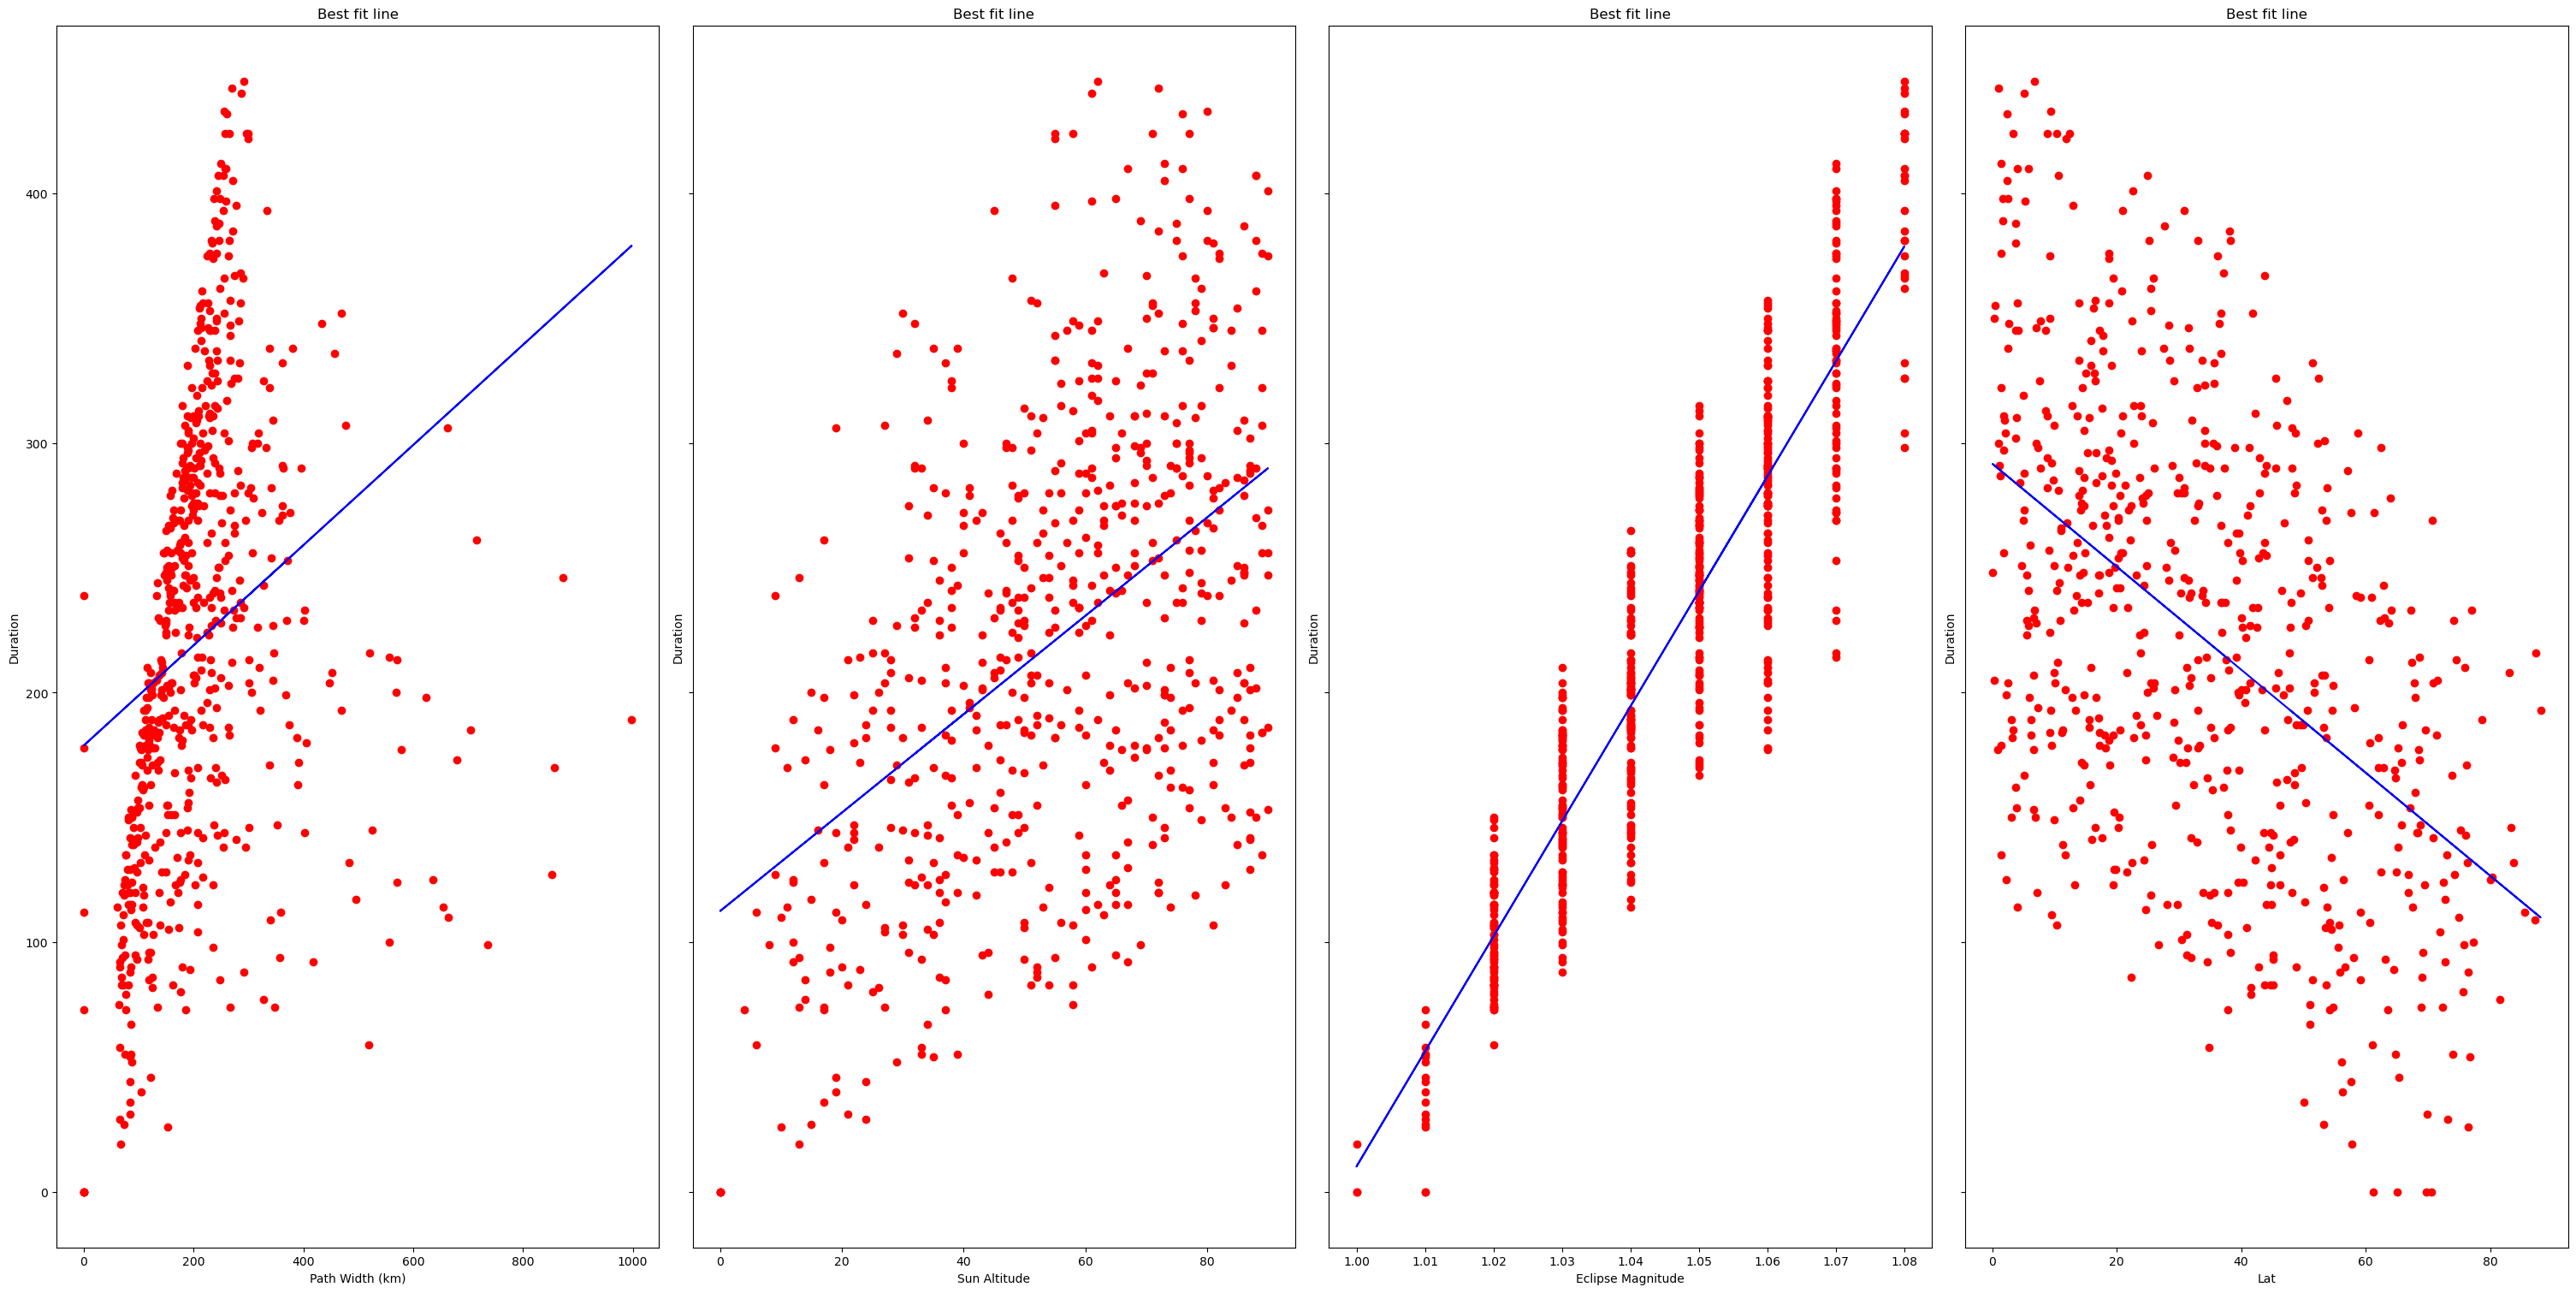

In [66]:
# Create DataFrames for Y_test and y_test_pred
y_results = pd.DataFrame(Y_test, columns=['Eclipse'])
print(y_results.shape)

y_predicted = pd.DataFrame(y_test_pred, columns=['Eclipse'])
print(y_predicted.shape)

# Ensure there are no duplicate columns and 'values' is defined correctly
x_values = pd.DataFrame(X_test, columns=['Path Width (km)', 'Sun Altitude', 'Eclipse Magnitude', 'Lat'])
print(x_values.shape)

# Create subplots
fig, axes = plt.subplots(1, len(x_values.columns), sharey=True, constrained_layout=True, figsize=(30, 15))

# Iterate over each column in x_values
for i, e in enumerate(x_values.columns):
    # Fit the model
    lm.fit(x_values[e].values[:, np.newaxis], y_results.values)
    
    # Plotting
    axes[i].set_title("Best fit line")
    axes[i].set_xlabel(str(e))
    axes[i].set_ylabel('Duration')
    axes[i].scatter(x_values[e].values[:, np.newaxis], y_results, color='r')
    axes[i].plot(x_values[e].values[:, np.newaxis], lm.predict(x_values[e].values[:, np.newaxis]), color='b')

plt.show()